# Predict Bio-Torque with XGBoost (Subject Independent)

## Process Data


### Create list of header names for the features and labels

In [1]:
#Create the Feature Table Names

feature_table_names = []


#col_names = ['right_FP_x', 'right_FP_y', 'right_FP_z', 
#          'left_FP_x', 'left_FP_y', 'left_FP_z', 
#          'shank_acc_x', 'shank_acc_y', 'shank_acc_z', 'shank_gyro_x', 'shank_gyro_y', 'shank_gyro_z' ,
#          'foot_acc_x', 'foot_acc_y', 'foot_acc_z', 'foot_gyro_x', 'foot_gyro_y', 'foot_gyro_z', 
#          'thigh_acc_x', 'thigh_acc_y', 'thigh_acc_z', 'thigh_gyro_x', 'thigh_gyro_y', 'thigh_gyro_z', 
#          'torso_acc_x', 'torso_acc_y', 'torso_acc_z', 'torso_gyro_x', 'torso_gyro_y', 'torso_gyro_z',]
col_names = ['shank_acc_x', 'shank_acc_y', 'shank_acc_z', 'shank_gyro_x', 'shank_gyro_y', 'shank_gyro_z' ,
           'foot_acc_x', 'foot_acc_y', 'foot_acc_z', 'foot_gyro_x', 'foot_gyro_y', 'foot_gyro_z', 
           'thigh_acc_x', 'thigh_acc_y', 'thigh_acc_z', 'thigh_gyro_x', 'thigh_gyro_y', 'thigh_gyro_z', 
          'torso_acc_x', 'torso_acc_y', 'torso_acc_z', 'torso_gyro_x', 'torso_gyro_y', 'torso_gyro_z'
          ]
col_feat = ['min_','max_', 'mean_', 'std_', 'end_']


#feature_table_length = col_names*col_feat

for i in range(len(col_names)):
    for j in range(len(col_feat)):
    
        
        feature_table_names.append(col_feat[j]+col_names[i])

        
        



        
#Create labels for ground truth labels
ground_truth_names = ['hip_torque','knee_torque', 'L5_S1_flex_torque']


#print(feature_table_names)
    
#len(feature_table_names)

In [2]:
def kalman(measurement_list, process_noise, variance, pipeline, files=None):
    """Kalman filter
    Args:
        measurement_list ([float]): A time-ordered series of environmental estimates
        process_noise (float): Approximate process noise for the estimation process.
        variance (float or [float]): Either a single value (for static variance)
            or a list of values (for dynamic variance)
    Returns:
        [float]: Kalman filtered estimate buffer
    """
    if len(measurement_list) <= 1:
        return measurement_list
    dyn_variance = type(variance) is not float
    estimate_buffer = []
    if 'Speed' in pipeline:
        prior_estimate = 0.6
        prior_variance = 0.2 if dyn_variance else variance
    elif 'Slope' in pipeline:
        prior_estimate = 10
        prior_variance = 1 if dyn_variance else variance
    elif 'Height' in pipeline:
        prior_estimate = 15
        prior_variance = 1.2 if dyn_variance else variance

    for i in range(len(measurement_list)):
        if files is None or files[i] == files[i - 1]:
            # Zn Measurements
            single_measurement = measurement_list[i]
            #single_variance = abs(variance[i]) if dyn_variance else variance
            single_variance = variance
            # Update
            k_gain = prior_variance / (prior_variance + single_variance)
            if estimate_buffer:
                estimate = estimate_buffer[i - 1] + k_gain * (single_measurement - estimate_buffer[i - 1])
            else:
                estimate = prior_estimate + k_gain * (single_measurement - prior_estimate)
            estimate_buffer.append(estimate)

            # Update Variance
            prior_variance = (1 - k_gain) * prior_variance + process_noise
        else:
            estimate_buffer.append(measurement_list[i])
            #prior_variance = abs(variance[i]) if dyn_variance else variance
            prior_variance = variance
    return np.array(estimate_buffer)

# 0 Degree Lifts

### Loop through test subjects to get their RMSE and R2 score

In [3]:
#Stack Data for training

import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#subject_num = ['04', '05', '06', '07', '09','10','11','12','14','15']
subject_num = ['04', '05', '06', '07', '09','10','15']
lift_type = 'KW'

lift_degree = 0

overall_rmse = []
overall_r2 = []

for c in range(0,len(subject_num)):
    
    
    test_sub = subject_num[c]
    
    


    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    if test_sub == subject_num[0]:
        start_i = 1
    else:
        start_i = 0

    for j in range(start_i,len(subject_num)):
        if subject_num[j] == test_sub:
                message = "--- Subject "+str(subject_num[j])+" is test Trial --- "
                print('---------------')
                print(message)
                print('---------------')
        else:
            for i in range(1,8):

    
                    print(j)
                    message = "--- Adding Subject "+ str(subject_num[j]) + " Trial " +str(i)+"  to the training data ---"
                    print(message)
                    file = "D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_"+str(subject_num[j])+"_L_"+str(lift_degree)+"_"+lift_type+"_0"+str(i)+".csv"
                    #data = pd.read_csv(file, names = feature_table_names)
                    data = pd.read_csv(file)
                    print("Data Row: "+str(data.shape[0]))
                    #print('Trial: '+str(i))
                    #print(data.info())
                    #print('------------------------------')
                    data_train = pd.concat([data_train,data],ignore_index=True)




    print('Train Trials:')
    print(data_train.info())
    
    x_train = data_train[feature_table_names]
    y_train = data_train[ground_truth_names]

    print('Train Trials:')
    print(x_train.info())
    
    sc=StandardScaler()

    scaler = sc.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
               
    # Create Models


    model_L5S1 = XGBRegressor()

    kernel_size = 10
    kernel = np.ones(kernel_size) / kernel_size
    GT_lumbar_torque = y_train.L5_S1_flex_torque
    data_convolved = np.convolve(GT_lumbar_torque, kernel, mode='same')

    model_L5S1.fit(x_train_scaled,data_convolved)


    #Predict the test set results 

    r2_array_back = []
    rmse_array_back =[]




    for i in range(1,8):


        file = "D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_"+str(test_sub)+"_L_"+str(lift_degree)+"_"+lift_type+"_0"+str(i)+".csv"
        message = "--- Testing on "+ str(test_sub) + " Trial " +str(i)+" ---"
        print(message)

        data_test = pd.read_csv(file)

        x_test = data_test[feature_table_names]
        x_test_scaled = scaler.transform(x_test)
        y_test = data_test[ground_truth_names]


        y_pred_back =  model_L5S1.predict(x_test_scaled)

        #Plot prediction vs ground truth of hip

        process_noise = 0.1
        variance = np.var(y_pred_back)
        #print(variance)
        pipeline = 'Speed'

        ML_pred_filtered = kalman(y_pred_back, process_noise, variance,pipeline)


        data_convolved = np.convolve(y_test.L5_S1_flex_torque, kernel, mode='same')
        rmse = np.sqrt(np.mean((ML_pred_filtered - data_convolved)**2))
        r2 = r2_score(data_convolved, ML_pred_filtered)



        message = 'RMSE: '+str(rmse)
        print(message)
        message = 'R squared '+str(r2)
        print(message)

        rmse_array_back.append(rmse)
        r2_array_back.append(r2)


    
    message = 'Subject '+ str(test_sub)
    print('---------------------')
    print(message)
    print('---------------------')
    sub_avg_rmse = np.mean(rmse_array_back)
    sub_avg_r2 = np.mean(r2_array_back)
    print(sub_avg_rmse)
    print(sub_avg_r2)
    overall_rmse.append(sub_avg_rmse)
    overall_r2.append(sub_avg_r2)





1
--- Adding Subject 05 Trial 1  to the training data ---
Data Row: 128
1
--- Adding Subject 05 Trial 2  to the training data ---
Data Row: 126
1
--- Adding Subject 05 Trial 3  to the training data ---
Data Row: 130
1
--- Adding Subject 05 Trial 4  to the training data ---
Data Row: 134
1
--- Adding Subject 05 Trial 5  to the training data ---
Data Row: 125
1
--- Adding Subject 05 Trial 6  to the training data ---
Data Row: 128
1
--- Adding Subject 05 Trial 7  to the training data ---
Data Row: 138
2
--- Adding Subject 06 Trial 1  to the training data ---
Data Row: 141
2
--- Adding Subject 06 Trial 2  to the training data ---
Data Row: 128
2
--- Adding Subject 06 Trial 3  to the training data ---
Data Row: 132
2
--- Adding Subject 06 Trial 4  to the training data ---
Data Row: 121
2
--- Adding Subject 06 Trial 5  to the training data ---
Data Row: 128
2
--- Adding Subject 06 Trial 6  to the training data ---
Data Row: 119
2
--- Adding Subject 06 Trial 7  to the training data ---
Data R

0
--- Adding Subject 04 Trial 7  to the training data ---
Data Row: 101
1
--- Adding Subject 05 Trial 1  to the training data ---
Data Row: 128
1
--- Adding Subject 05 Trial 2  to the training data ---
Data Row: 126
1
--- Adding Subject 05 Trial 3  to the training data ---
Data Row: 130
1
--- Adding Subject 05 Trial 4  to the training data ---
Data Row: 134
1
--- Adding Subject 05 Trial 5  to the training data ---
Data Row: 125
1
--- Adding Subject 05 Trial 6  to the training data ---
Data Row: 128
1
--- Adding Subject 05 Trial 7  to the training data ---
Data Row: 138
---------------
--- Subject 06 is test Trial --- 
---------------
3
--- Adding Subject 07 Trial 1  to the training data ---
Data Row: 141
3
--- Adding Subject 07 Trial 2  to the training data ---
Data Row: 121
3
--- Adding Subject 07 Trial 3  to the training data ---
Data Row: 106
3
--- Adding Subject 07 Trial 4  to the training data ---
Data Row: 114
3
--- Adding Subject 07 Trial 5  to the training data ---
Data Row: 11

0
--- Adding Subject 04 Trial 7  to the training data ---
Data Row: 101
1
--- Adding Subject 05 Trial 1  to the training data ---
Data Row: 128
1
--- Adding Subject 05 Trial 2  to the training data ---
Data Row: 126
1
--- Adding Subject 05 Trial 3  to the training data ---
Data Row: 130
1
--- Adding Subject 05 Trial 4  to the training data ---
Data Row: 134
1
--- Adding Subject 05 Trial 5  to the training data ---
Data Row: 125
1
--- Adding Subject 05 Trial 6  to the training data ---
Data Row: 128
1
--- Adding Subject 05 Trial 7  to the training data ---
Data Row: 138
2
--- Adding Subject 06 Trial 1  to the training data ---
Data Row: 141
2
--- Adding Subject 06 Trial 2  to the training data ---
Data Row: 128
2
--- Adding Subject 06 Trial 3  to the training data ---
Data Row: 132
2
--- Adding Subject 06 Trial 4  to the training data ---
Data Row: 121
2
--- Adding Subject 06 Trial 5  to the training data ---
Data Row: 128
2
--- Adding Subject 06 Trial 6  to the training data ---
Data R

0
--- Adding Subject 04 Trial 7  to the training data ---
Data Row: 101
1
--- Adding Subject 05 Trial 1  to the training data ---
Data Row: 128
1
--- Adding Subject 05 Trial 2  to the training data ---
Data Row: 126
1
--- Adding Subject 05 Trial 3  to the training data ---
Data Row: 130
1
--- Adding Subject 05 Trial 4  to the training data ---
Data Row: 134
1
--- Adding Subject 05 Trial 5  to the training data ---
Data Row: 125
1
--- Adding Subject 05 Trial 6  to the training data ---
Data Row: 128
1
--- Adding Subject 05 Trial 7  to the training data ---
Data Row: 138
2
--- Adding Subject 06 Trial 1  to the training data ---
Data Row: 141
2
--- Adding Subject 06 Trial 2  to the training data ---
Data Row: 128
2
--- Adding Subject 06 Trial 3  to the training data ---
Data Row: 132
2
--- Adding Subject 06 Trial 4  to the training data ---
Data Row: 121
2
--- Adding Subject 06 Trial 5  to the training data ---
Data Row: 128
2
--- Adding Subject 06 Trial 6  to the training data ---
Data R

### Look at R squared and RMSE 

0.7743914373193918
0.09098367961927996


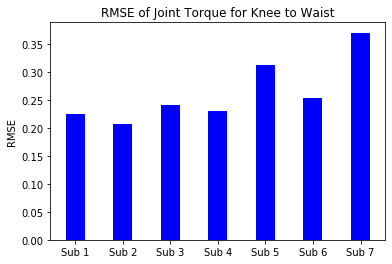

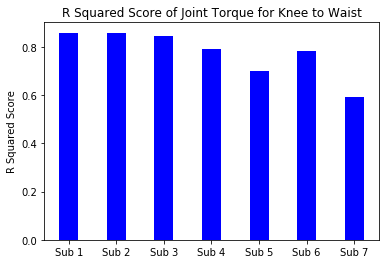

In [4]:
#print(overall_rmse)
#print(overall_r2)

#print(np.mean(overall_rmse))
#print(np.mean(overall_r2))

#subs_name = ['Sub 1','Sub 2','Sub 3','Sub 4','Sub 5','Sub 6','Sub 7','Sub 8','Sub 9','Sub 10']
subs_name = ['Sub 1','Sub 2','Sub 3','Sub 4','Sub 5','Sub 6','Sub 7']
plt.figure()
plt.bar(subs_name, overall_rmse, color ='blue',width = 0.4)
plt.ylabel("RMSE")
plt.title("RMSE of Joint Torque for Knee to Waist")

plt.figure()
plt.bar(subs_name, overall_r2, color ='blue',width = 0.4)
plt.ylabel("R Squared Score")
plt.title("R Squared Score of Joint Torque for Knee to Waist")

#print(np.mean(overall_rmse))
print(np.mean(overall_r2))
print(np.std(overall_r2))

# 90 Degree Lifts

### Loop through test subjects to get their RMSE and R2 score



In [5]:
#Stack Data for training

import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

subject_num = ['04', '05', '06', '07', '09','10','15']
lift_type = 'KW'
lift_side = 'R'
lift_degree = 90

overall_rmse = []
overall_r2 = []

for c in range(0,len(subject_num)):
    
    
    test_sub = subject_num[c]
    
    


    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    if test_sub == subject_num[0]:
        start_i = 1
    else:
        start_i = 0

    for j in range(start_i,len(subject_num)):
        if subject_num[j] == test_sub:
                message = "--- Subject "+str(subject_num[j])+" is test Trial --- "
                print('---------------')
                print(message)
                print('---------------')
        else:
            for i in range(1,8):

    
                    print(j)
                    message = "--- Adding Subject "+ str(subject_num[j]) + " Trial " +str(i)+"  to the training data ---"
                    print(message)
                    file = "D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_"+str(subject_num[j])+"_L_"+str(lift_degree)+"_"+lift_side+"_"+lift_type+"_0"+str(i)+".csv"
                    print(file)
                    #data = pd.read_csv(file, names = feature_table_names)
                    data = pd.read_csv(file)
                    print("Data Row: "+str(data.shape[0]))
                    #print('Trial: '+str(i))
                    #print(data.info())
                    #print('------------------------------')
                    data_train = pd.concat([data_train,data],ignore_index=True)




    print('Train Trials:')
    print(data_train.info())
    
    x_train = data_train[feature_table_names]
    y_train = data_train[ground_truth_names]

    print('Train Trials:')
    print(x_train.info())
    
    sc=StandardScaler()

    scaler = sc.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
               
    # Create Models


    model_L5S1 = XGBRegressor()

    kernel_size = 10
    kernel = np.ones(kernel_size) / kernel_size
    GT_lumbar_torque = y_train.L5_S1_flex_torque
    data_convolved = np.convolve(GT_lumbar_torque, kernel, mode='same')

    model_L5S1.fit(x_train_scaled,data_convolved)


    #Predict the test set results 

    r2_array_back = []
    rmse_array_back =[]




    for i in range(1,8):


        file = "D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_"+str(test_sub)+"_L_"+str(lift_degree)+"_"+lift_side+"_"+lift_type+"_0"+str(i)+".csv"
        print(file)
        message = "--- Testing on "+ str(test_sub) + " Trial " +str(i)+" ---"
        print(message)

        data_test = pd.read_csv(file)

        x_test = data_test[feature_table_names]
        x_test_scaled = scaler.transform(x_test)
        y_test = data_test[ground_truth_names]


        y_pred_back =  model_L5S1.predict(x_test_scaled)

        #Plot prediction vs ground truth of hip

        process_noise = 0.1
        variance = np.var(y_pred_back)
        #print(variance)
        pipeline = 'Speed'

        ML_pred_filtered = kalman(y_pred_back, process_noise, variance,pipeline)


        data_convolved = np.convolve(y_test.L5_S1_flex_torque, kernel, mode='same')
        rmse = np.sqrt(np.mean((ML_pred_filtered - data_convolved)**2))
        r2 = r2_score(data_convolved, ML_pred_filtered)



        message = 'RMSE: '+str(rmse)
        print(message)
        message = 'R squared '+str(r2)
        print(message)

        rmse_array_back.append(rmse)
        r2_array_back.append(r2)


    
    message = 'Subject '+ str(test_sub)
    print('---------------------')
    print(message)
    print('---------------------')
    sub_avg_rmse = np.mean(rmse_array_back)
    sub_avg_r2 = np.mean(r2_array_back)
    print(sub_avg_rmse)
    print(sub_avg_r2)
    overall_rmse.append(sub_avg_rmse)
    overall_r2.append(sub_avg_r2)






1
--- Adding Subject 05 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_01.csv
Data Row: 116
1
--- Adding Subject 05 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_02.csv
Data Row: 124
1
--- Adding Subject 05 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_03.csv
Data Row: 130
1
--- Adding Subject 05 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_04.csv
Data Row: 133
1
--- Adding Subject 05 Trial 5  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/resu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5605 entries, 0 to 5604
Columns: 168 entries, min_right_FP_x to L5_S1_flex_torque
dtypes: float64(168)
memory usage: 7.2 MB
None
Train Trials:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5605 entries, 0 to 5604
Columns: 120 entries, min_shank_acc_x to end_torso_gyro_z
dtypes: float64(120)
memory usage: 5.1 MB
None
[09:15:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_04_L_90_R_KW_01.csv
--- Testing on 04 Trial 1 ---
RMSE: 0.1613828101437174
R squared 0.9250520505051997
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_04_L_90_R_KW_02.csv
--- Testing on 04 Trial 2 ---
RMSE: 0.16879946304847257
R squared 0.9250326763458869
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis

Data Row: 140
5
--- Adding Subject 10 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_10_L_90_R_KW_04.csv
Data Row: 141
5
--- Adding Subject 10 Trial 5  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_10_L_90_R_KW_05.csv
Data Row: 134
5
--- Adding Subject 10 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_10_L_90_R_KW_06.csv
Data Row: 134
5
--- Adding Subject 10 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_10_L_90_R_KW_07.csv
Data Row: 141
6
--- Adding Subject 15 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/sc

3
--- Adding Subject 07 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_06.csv
Data Row: 101
3
--- Adding Subject 07 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_07.csv
Data Row: 110
4
--- Adding Subject 09 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_90_R_KW_01.csv
Data Row: 147
4
--- Adding Subject 09 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_90_R_KW_02.csv
Data Row: 147
4
--- Adding Subject 09 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/resu

0
--- Adding Subject 04 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_04_L_90_R_KW_07.csv
Data Row: 103
1
--- Adding Subject 05 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_01.csv
Data Row: 116
1
--- Adding Subject 05 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_02.csv
Data Row: 124
1
--- Adding Subject 05 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_03.csv
Data Row: 130
1
--- Adding Subject 05 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/resu

D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_01.csv
--- Testing on 07 Trial 1 ---
RMSE: 0.26503026836975
R squared 0.7647028046112716
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_02.csv
--- Testing on 07 Trial 2 ---
RMSE: 0.32392539578071317
R squared 0.7152086816314389
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_03.csv
--- Testing on 07 Trial 3 ---
RMSE: 0.31175404689588737
R squared 0.757632705140674
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_04.csv
--- Testing on 07 Trial 4 ---
RMSE: 0.30973592122073007
R squared 0.8037237489653739
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/featur

Data Row: 134
5
--- Adding Subject 10 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_10_L_90_R_KW_06.csv
Data Row: 134
5
--- Adding Subject 10 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_10_L_90_R_KW_07.csv
Data Row: 141
6
--- Adding Subject 15 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_90_R_KW_01.csv
Data Row: 131
6
--- Adding Subject 15 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_90_R_KW_02.csv
Data Row: 125
6
--- Adding Subject 15 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/sc

2
--- Adding Subject 06 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_06_L_90_R_KW_07.csv
Data Row: 159
3
--- Adding Subject 07 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_01.csv
Data Row: 133
3
--- Adding Subject 07 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_02.csv
Data Row: 120
3
--- Adding Subject 07 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_90_R_KW_03.csv
Data Row: 115
3
--- Adding Subject 07 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/resu

0
--- Adding Subject 04 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_04_L_90_R_KW_07.csv
Data Row: 103
1
--- Adding Subject 05 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_01.csv
Data Row: 116
1
--- Adding Subject 05 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_02.csv
Data Row: 124
1
--- Adding Subject 05 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_90_R_KW_03.csv
Data Row: 130
1
--- Adding Subject 05 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/resu

D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_90_R_KW_01.csv
--- Testing on 15 Trial 1 ---
RMSE: 0.20236937047560297
R squared 0.9174423448531142
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_90_R_KW_02.csv
--- Testing on 15 Trial 2 ---
RMSE: 0.20040144159445544
R squared 0.8800428179600981
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_90_R_KW_03.csv
--- Testing on 15 Trial 3 ---
RMSE: 0.20205291919825807
R squared 0.8618283271395228
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_90_R_KW_04.csv
--- Testing on 15 Trial 4 ---
RMSE: 0.21280611444653869
R squared 0.8034268502586823
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/fe

### Look at R squared and RMSE 

[0.17502589845983363, 0.22932258829764346, 0.31167083655366173, 0.29913220046365946, 0.2814644809151173, 0.31214046335620527, 0.1921868205190318]
[0.9113963987462526, 0.8078442054963269, 0.7504926405452009, 0.7654061906886991, 0.7432504166526928, 0.8136694574740532, 0.8712685796235704]
0.8090468413181137
0.058593102776447345


Text(0.5, 1.0, 'R Squared Score of Joint Torque for Knee to Waist')

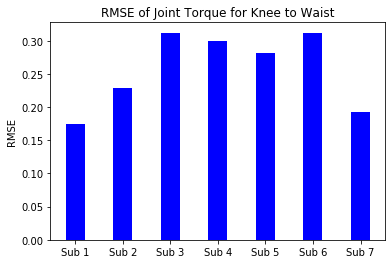

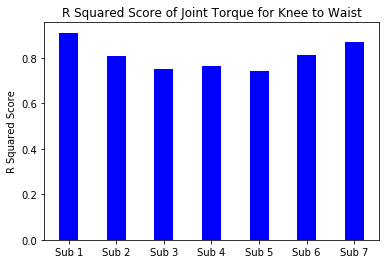

In [6]:
print(overall_rmse)
print(overall_r2)

print(np.mean(overall_r2))
print(np.std(overall_r2))

subs_name = ['Sub 1','Sub 2','Sub 3','Sub 4','Sub 5','Sub 6','Sub 7']
#subs_name = ['Sub 1','Sub 2','Sub 3','Sub 4','Sub 5','Sub 6','Sub 7','Sub 8','Sub 9']
plt.figure()
plt.bar(subs_name, overall_rmse, color ='blue',width = 0.4)
plt.ylabel("RMSE")
plt.title("RMSE of Joint Torque for Knee to Waist")

plt.figure()
plt.bar(subs_name, overall_r2, color ='blue',width = 0.4)
plt.ylabel("R Squared Score")
plt.title("R Squared Score of Joint Torque for Knee to Waist")



# 180 Degree Lifts

### Loop through test subjects to get their RMSE and R2 score


In [7]:
#Stack Data for training

import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

subject_num = ['04', '05', '06', '07', '09','10','15']
lift_type = 'KW'
lift_side = 'R'
lift_degree = 180

overall_rmse = []
overall_r2 = []

for c in range(0,len(subject_num)):
    
    
    test_sub = subject_num[c]
    
    


    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    if test_sub == subject_num[0]:
        start_i = 1
    else:
        start_i = 0

    for j in range(start_i,len(subject_num)):
        if subject_num[j] == test_sub:
                message = "--- Subject "+str(subject_num[j])+" is test Trial --- "
                print('---------------')
                print(message)
                print('---------------')
        else:
            for i in range(1,8):

    
                    print(j)
                    message = "--- Adding Subject "+ str(subject_num[j]) + " Trial " +str(i)+"  to the training data ---"
                    print(message)
                    file = "D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_"+str(subject_num[j])+"_L_"+str(lift_degree)+"_"+lift_side+"_"+lift_type+"_0"+str(i)+".csv"
                    print(file)
                    #data = pd.read_csv(file, names = feature_table_names)
                    data = pd.read_csv(file)
                    print("Data Row: "+str(data.shape[0]))
                    #print('Trial: '+str(i))
                    #print(data.info())
                    #print('------------------------------')
                    data_train = pd.concat([data_train,data],ignore_index=True)




    print('Train Trials:')
    print(data_train.info())
    
    x_train = data_train[feature_table_names]
    y_train = data_train[ground_truth_names]

    print('Train Trials:')
    print(x_train.info())
    
    sc=StandardScaler()

    scaler = sc.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
               
    # Create Models


    model_L5S1 = XGBRegressor()

    kernel_size = 10
    kernel = np.ones(kernel_size) / kernel_size
    GT_lumbar_torque = y_train.L5_S1_flex_torque
    data_convolved = np.convolve(GT_lumbar_torque, kernel, mode='same')

    model_L5S1.fit(x_train_scaled,data_convolved)


    #Predict the test set results 

    r2_array_back = []
    rmse_array_back =[]




    for i in range(1,8):


        file = "D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_"+str(test_sub)+"_L_"+str(lift_degree)+"_"+lift_side+"_"+lift_type+"_0"+str(i)+".csv"
        print(file)
        message = "--- Testing on "+ str(test_sub) + " Trial " +str(i)+" ---"
        print(message)

        data_test = pd.read_csv(file)

        x_test = data_test[feature_table_names]
        x_test_scaled = scaler.transform(x_test)
        y_test = data_test[ground_truth_names]


        y_pred_back =  model_L5S1.predict(x_test_scaled)

        #Plot prediction vs ground truth of hip

        process_noise = 0.1
        variance = np.var(y_pred_back)
        #print(variance)
        pipeline = 'Speed'

        ML_pred_filtered = kalman(y_pred_back, process_noise, variance,pipeline)


        data_convolved = np.convolve(y_test.L5_S1_flex_torque, kernel, mode='same')
        rmse = np.sqrt(np.mean((ML_pred_filtered - data_convolved)**2))
        r2 = r2_score(data_convolved, ML_pred_filtered)



        message = 'RMSE: '+str(rmse)
        print(message)
        message = 'R squared '+str(r2)
        print(message)

        rmse_array_back.append(rmse)
        r2_array_back.append(r2)


    
    message = 'Subject '+ str(test_sub)
    print('---------------------')
    print(message)
    print('---------------------')
    sub_avg_rmse = np.mean(rmse_array_back)
    sub_avg_r2 = np.mean(r2_array_back)
    print(sub_avg_rmse)
    print(sub_avg_r2)
    overall_rmse.append(sub_avg_rmse)
    overall_r2.append(sub_avg_r2)




1
--- Adding Subject 05 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_01.csv
Data Row: 136
1
--- Adding Subject 05 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_02.csv
Data Row: 139
1
--- Adding Subject 05 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_03.csv
Data Row: 136
1
--- Adding Subject 05 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_04.csv
Data Row: 135
1
--- Adding Subject 05 Trial 5  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/

Train Trials:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5980 entries, 0 to 5979
Columns: 168 entries, min_right_FP_x to L5_S1_flex_torque
dtypes: float64(168)
memory usage: 7.7 MB
None
Train Trials:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5980 entries, 0 to 5979
Columns: 120 entries, min_shank_acc_x to end_torso_gyro_z
dtypes: float64(120)
memory usage: 5.5 MB
None
[09:16:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_04_L_180_R_KW_01.csv
--- Testing on 04 Trial 1 ---
RMSE: 0.14828754216347018
R squared 0.9370510736357636
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_04_L_180_R_KW_02.csv
--- Testing on 04 Trial 2 ---
RMSE: 0.13505464288359414
R squared 0.9593318764285546
D:/Dropbox (GaTech)/DOE_Exos/Exp

Data Row: 132
5
--- Adding Subject 10 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_10_L_180_R_KW_06.csv
Data Row: 135
5
--- Adding Subject 10 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_10_L_180_R_KW_07.csv
Data Row: 141
6
--- Adding Subject 15 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_180_R_KW_01.csv
Data Row: 141
6
--- Adding Subject 15 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_180_R_KW_02.csv
Data Row: 132
6
--- Adding Subject 15 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysi

3
--- Adding Subject 07 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_180_R_KW_06.csv
Data Row: 116
3
--- Adding Subject 07 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_180_R_KW_07.csv
Data Row: 111
4
--- Adding Subject 09 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_01.csv
Data Row: 169
4
--- Adding Subject 09 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_02.csv
Data Row: 147
4
--- Adding Subject 09 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/

Data Row: 153
2
--- Adding Subject 06 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_06_L_180_R_KW_03.csv
Data Row: 153
2
--- Adding Subject 06 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_06_L_180_R_KW_04.csv
Data Row: 157
2
--- Adding Subject 06 Trial 5  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_06_L_180_R_KW_05.csv
Data Row: 157
2
--- Adding Subject 06 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_06_L_180_R_KW_06.csv
Data Row: 142
2
--- Adding Subject 06 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysi

0
--- Adding Subject 04 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_04_L_180_R_KW_07.csv
Data Row: 113
1
--- Adding Subject 05 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_01.csv
Data Row: 136
1
--- Adding Subject 05 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_02.csv
Data Row: 139
1
--- Adding Subject 05 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_05_L_180_R_KW_03.csv
Data Row: 136
1
--- Adding Subject 05 Trial 4  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/

[09:16:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_01.csv
--- Testing on 09 Trial 1 ---
RMSE: 0.26824165624627283
R squared 0.789227056217394
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_02.csv
--- Testing on 09 Trial 2 ---
RMSE: 0.23836311744692806
R squared 0.8030742255200427
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_03.csv
--- Testing on 09 Trial 3 ---
RMSE: 0.23071749291293253
R squared 0.8399822625717623
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_04.csv
--- Testing on 09 Trial 4 ---
RMSE: 0.

4
--- Adding Subject 09 Trial 5  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_05.csv
Data Row: 152
4
--- Adding Subject 09 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_06.csv
Data Row: 161
4
--- Adding Subject 09 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_09_L_180_R_KW_07.csv
Data Row: 146
---------------
--- Subject 10 is test Trial --- 
---------------
6
--- Adding Subject 15 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_15_L_180_R_KW_01.csv
Data Row: 141
6
--- Adding Subject 15 Trial 2  to the training data 

2
--- Adding Subject 06 Trial 6  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_06_L_180_R_KW_06.csv
Data Row: 142
2
--- Adding Subject 06 Trial 7  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_06_L_180_R_KW_07.csv
Data Row: 166
3
--- Adding Subject 07 Trial 1  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_180_R_KW_01.csv
Data Row: 138
3
--- Adding Subject 07 Trial 2  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/results/feature_tables/100_ms_window_20_ms_increment/DOE_Biomech_07_L_180_R_KW_02.csv
Data Row: 123
3
--- Adding Subject 07 Trial 3  to the training data ---
D:/Dropbox (GaTech)/DOE_Exos/Experiments/Analysis/scale_ik_id/

[0.15537893371187647, 0.25266355915106053, 0.2396551553464196, 0.23711011371265167, 0.23277987088043658, 0.2496012502942371, 0.23606969543413658]
[0.9458091275116794, 0.7090889216692731, 0.8621483229510869, 0.8676463332598393, 0.8362754016215053, 0.8636646913167716, 0.7714178214684375]
0.8365786599712276
0.07049175872189724


Text(0.5, 1.0, 'R Squared Score of Joint Torque for Knee to Waist')

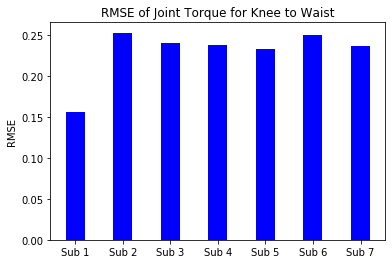

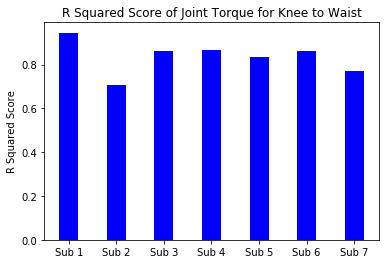

In [8]:
print(overall_rmse)
print(overall_r2)

print(np.mean(overall_r2))
print(np.std(overall_r2))


subs_name = ['Sub 1','Sub 2','Sub 3','Sub 4','Sub 5','Sub 6','Sub 7']
#subs_name = ['Sub 1','Sub 2','Sub 3','Sub 4','Sub 5','Sub 6','Sub 7','Sub 8','Sub 9']
plt.figure()
plt.bar(subs_name, overall_rmse, color ='blue',width = 0.4)
plt.ylabel("RMSE")
plt.title("RMSE of Joint Torque for Knee to Waist")

plt.figure()
plt.bar(subs_name, overall_r2, color ='blue',width = 0.4)
plt.ylabel("R Squared Score")
plt.title("R Squared Score of Joint Torque for Knee to Waist")



In [4]:
import matlab.engine

eng = matlab.engine.start_matlab()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
subject = '05'
degree = 0
side = 'R'
lift_type = 'KW'
trial = '05'

if degree == 0:
    c3dFilePath = "D:\\Dropbox (Gatech)\\DOE_Exos\\Experiments\\DOE Biomechanics\\DOE_Biomech_"+subject+"_PROCESSED\\New Session\\DOE_Biomech_"+subject+"_L_"+str(degree)+"_"+lift_type+"_"+trial+"_filled.c3d"
else:
    c3dFilePath = "D:\\Dropbox (Gatech)\\DOE_Exos\\Experiments\\DOE Biomechanics\\DOE_Biomech_"+subject+"_PROCESSED\\New Session\\DOE_Biomech_"+subject+"_L_"+str(degree)+"_"+side+"_"+lift_type+"_"+trial+"_filled.c3d"
    

results_features, labels_features = eng.generate_feature_tables(c3dFilePath, degree)
df_features = pd.DataFrame(results_features,columns=labels_features)

x_test = df_features[feature_table_names]
x_test_scaled = scaler.transform(x_test)

y_pred_back =  model_L5S1.predict(x_test_scaled)


process_noise = 0.1
variance = np.var(y_pred_back)
#print(variance)
pipeline = 'Speed'

ML_pred_filtered = kalman(y_pred_back, process_noise, variance,pipeline)





In [ ]:
eng.quit()